# Tutorial Shapash Backend

This tutorial describes how to use the Shapash backend class with different implementations.
It also explains how to construct your own backend and connects it with Shapash.

Content:
- Build a classifier and an encoder
- Analyze the model with Shapash SmartExplainer (usual way)
- Add specific parameters to Shap explainer

We used Kaggle's [Titanic](https://www.kaggle.com/c/titanic) dataset and  [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [1]:
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.model_selection import train_test_split

from shapash.data.data_loader import data_loading
from shapash import SmartExplainer

In [2]:
titan_df, titan_dict = data_loading('titanic')
titan_df = titan_df.drop(columns='Name')

In [3]:
y = titan_df['Survived']
X = titan_df.drop(columns='Survived')

In [4]:
# Encode catgorical columns
onehot = OneHotEncoder(cols=['Pclass']).fit(X)
result_1 = onehot.transform(X)
ordinal = OrdinalEncoder(cols=['Embarked','Title']).fit(result_1)
result_2 = ordinal.transform(result_1)
target = TargetEncoder(cols=['Sex']).fit(result_2, y)
result_3 = target.transform(result_2)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [5]:
encoder = [onehot, ordinal, target] # Used by Shapash

In [6]:
Xtrain, Xtest, ytrain, ytest = train_test_split(result_3, y, train_size=0.75, random_state=1)

In [7]:
clf = RandomForestClassifier(n_estimators=10, min_samples_leaf=2, random_state=0).fit(Xtrain, ytrain)

### Default behaviour : shap backend

Below we use the usual way of compiling Shapash using Shap Explainer backend to compute local contributions.

In [8]:
xpl = SmartExplainer(model=clf, preprocessing=encoder, features_dict=titan_dict)

In [9]:
xpl.compile(x=Xtest,
    y_target=ytest, # Optional: allows to display True Values vs Predicted Values
    )

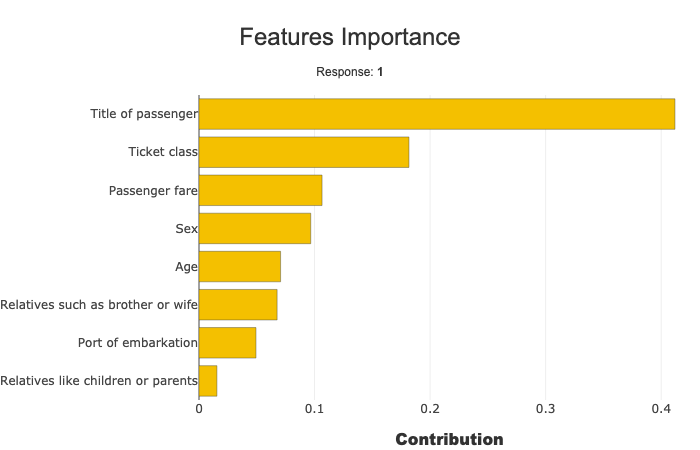

In [10]:
xpl.plot.features_importance()

### Add specific parameters to the backend 

You can add any parameters to the default Shap explainer using a python dict.  
Shapash will automatically pass it to the Shap explainer object as if they were usual args

In [11]:
# This way you can add any argument to the Shap Explainer object 
explainer_args = {"algorithm": "tree"}

xpl = SmartExplainer(
    model=clf, 
    preprocessing=encoder,
    features_dict=titan_dict,
    explainer_args=explainer_args
)

In [12]:
xpl.compile(x=Xtest)

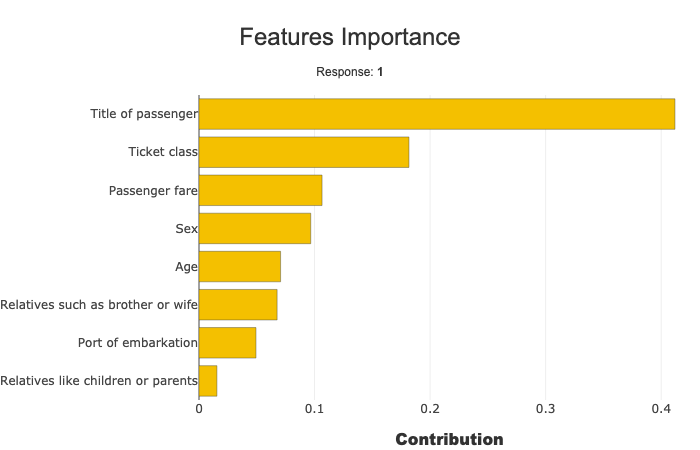

In [13]:
xpl.plot.features_importance()

### Change the bakckend used to compute local and global contributions

You can select another backend using the `backend` parameter.  

#### First way : using a string

The first way to select your backend is to indicate it using its string name.  
**Existing options are : 'shap' (default) and 'lime'.**
'acv' has been removed from release 2.3.8 because the librairy is not maintained.

Depending on the backend you select, there may be specific argument to pass.  
Please refer to the corresponding documentation for more details.  
For example, below we pass the `data` parameter used by Lime to declare the background.

In [14]:
xpl = SmartExplainer(
    model=clf, 
    preprocessing=encoder,
    backend='lime',
    data=Xtrain,  # Specific arg used by our backend (here Lime)
    features_dict=titan_dict
)

In [15]:
xpl.compile(x=Xtest.iloc[:20]) # Computations can take some time, we select only 20 observations

 40%|████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 4/10 [00:08<00:12,  2.06s/it]


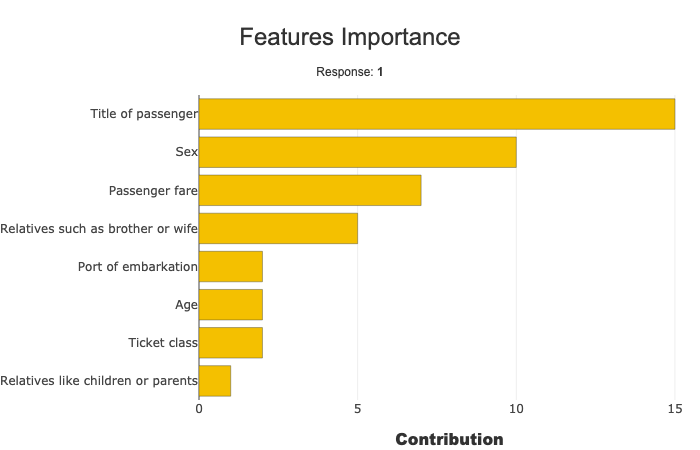

In [16]:
xpl.plot.features_importance()

#### Second way : using the backend class

Another way is to use the specific backend class and instanciate it before passing it to the `backend` parameter.  
Existing backend classes are : `ShapBackend` and `LimeBackend`

In [17]:
from shapash.backend import LimeBackend

lime_backend = LimeBackend(model=clf, data=Xtrain)

xpl = SmartExplainer(
    model=clf, 
    preprocessing=encoder,
    backend=lime_backend,
    features_dict=titan_dict
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 42.17it/s]


In [18]:
xpl.compile(x=Xtest.iloc[:20])

 40%|████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 4/10 [00:08<00:12,  2.01s/it]


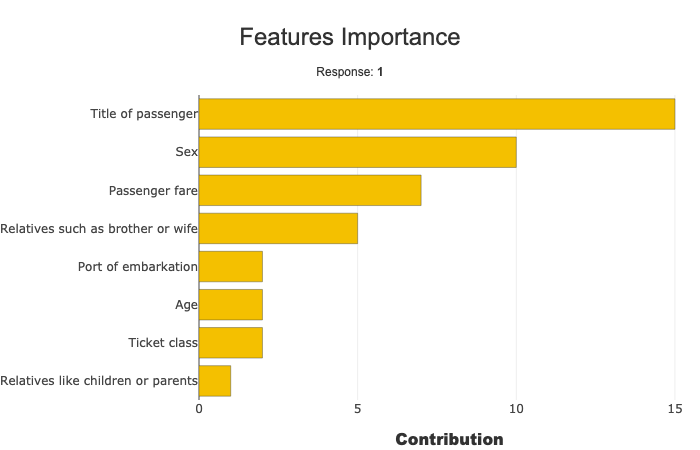

In [19]:
xpl.plot.features_importance()

### Define a custom backend

Finally can define your own backend inheriting the Shapash base backend class `BaseBackend`.

Each inherited class must at least define the following method : 
- `run_explainer` : this method should implement all computations that require time to execute. The result of this function (`explain_data` which should be a python dict containing at least `contributions` key) will then be used by other methods.

Below we define our own backend using KernelExplainer implemented by Shap with a regression example using the house prices dataset.

---

> Note : this implementation is very flexible and also allows to perform your own computations of local contributions and global feature importance. If you are interested in modifying the way to compute global features importance, for example, you can redefine the `get_global_features_importance` defined in the BaseBackend class. See the code of our implementation of AcvBackend for a complete example.

In [20]:
house_df, house_dict = data_loading('house_prices')

In [21]:
y2 = house_df['SalePrice'].to_frame()
X2 = house_df.drop(columns='SalePrice')

In [22]:
# Encode categorical features 

categorical_features = [col for col in X2.columns if X2[col].dtype == 'object']

encoder2 = OrdinalEncoder(
    cols=categorical_features, 
    handle_unknown='ignore', 
    return_df=True
).fit(X2)

X2 = encoder2.transform(X2)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [23]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.75, random_state=1)

In [24]:
# Train a model
model = RandomForestRegressor().fit(X2_train, y2_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [25]:
import shap
import logging
from shapash.backend import BaseBackend
logging.getLogger('shap').setLevel(logging.WARNING) # Disable info logs

class CustomShapBackend(BaseBackend):
    def __init__(self, model, data, preprocessing):
        super(CustomShapBackend, self).__init__(model, preprocessing)
        self.explainer = shap.KernelExplainer(model=model.predict, data=data)

    def run_explainer(self, x):
        shap_contributions = self.explainer.shap_values(x)
        explain_data = dict(contributions=shap_contributions)
        return explain_data

In [26]:
custom_backend = CustomShapBackend(model=model, data=X2_train.iloc[:20], preprocessing=encoder2)

xpl = SmartExplainer(
    model=model, 
    preprocessing=encoder2,
    backend=custom_backend,
    features_dict=house_dict
)

In [27]:
xpl.compile(x=X2_test.iloc[:15])

  0%|          | 0/15 [00:00<?, ?it/s]

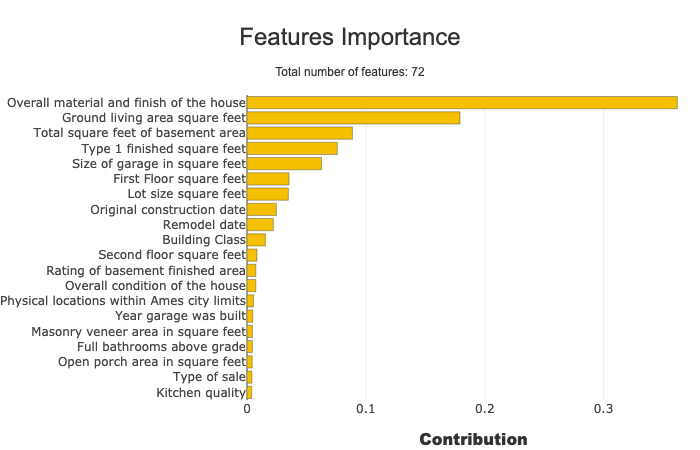

In [28]:
xpl.plot.features_importance()